# Objective
Test generalizability of parameters found in RCA pipeline test across the rest of the RCA acquisition

- Inputs:
    - 1 RCA FISH sample image
    - expert annotations of the sample image
    - 3 RCA FISH test images
- Operations: 
    - **Part 1**: parameter extraction from sample image
    - **Part 2**: blob detection on test images, using parameter extraction
    - **Part 3**: cropping of test images, using parameter extraction
    - **Part 4**: QC and reassembly of turker-annotated crops
    - **Part 5**: evaluation of precision and recall
- Outputs:
    - Consensus turker annotation coordinates
    - Precision and recall analysis


In [1]:
from sklearn.neighbors import KDTree
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from starfish.core.compat import match_histograms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
from fishanno import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, clus, param, util, vis

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


## User Inputs

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

In [3]:
sample_img_filename = 'ISS_rnd0_ch0_z0.png'
sample_img_path = './sample_image_filtered/' + sample_img_filename
sample_coords_filename = 'ISS_rnd0_ch0_z0.csv'
sample_coords_path = './sample_image_filtered/' + sample_coords_filename

In [4]:
test_img_filenames = ['ISS_rnd0_ch2_z0', 
                      'ISS_rnd1_ch0_z0', 
                      'ISS_rnd1_ch2_z0', 
                      'ISS_rnd1_ch3_z0', 
                      'ISS_rnd2_ch0_z0', 
                      'ISS_rnd2_ch1_z0', 
                      'ISS_rnd2_ch2_z0', 
                      'ISS_rnd2_ch3_z0', 
                      'ISS_rnd3_ch0_z0', 
                      'ISS_rnd3_ch1_z0', 
                      'ISS_rnd3_ch2_z0', 
                      'ISS_rnd3_ch3_z0']
test_img_paths = ['./test_images_filtered_add/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = ['./test_images_filtered_add/coords/%s.csv' % x for x in test_img_filenames]

# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection

### Run blob_log() on all test images.

In [6]:
blob_params = pd.read_csv('./sample_image_filtered/spot_params/' + sample_coords_filename)
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]

greatest_spot_sigma = 10.030000
smallest_spot_sigma = 0.670000
optimal_intensity_threshold = 0.220000

sample_im = imread(sample_img_path, as_gray=True)

for img_path in test_img_paths:

    im = imread(img_path, as_gray=True)
    im_normalized = match_histograms(im, sample_im, multichannel=False)
    img_height = len(im)
    
    if not os.path.exists('./test_images_filtered_add/blobs/'):
        os.mkdir('./test_images_filtered_add/blobs/')
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    
    blobs_log = blob_log(im_normalized, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, sigma in blobs_log]
    
    np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

### Plot Detected Blobs

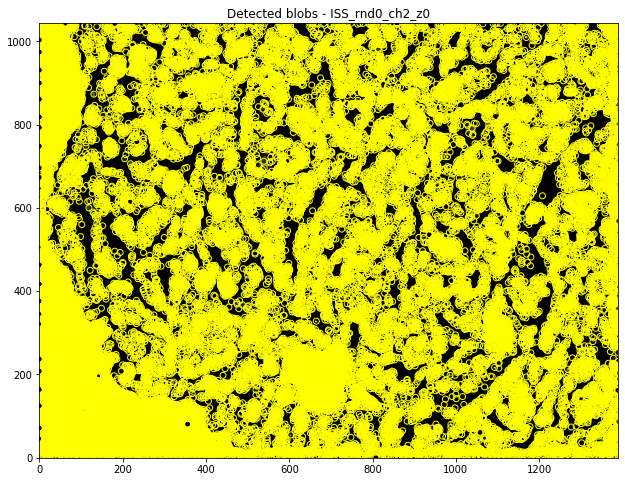

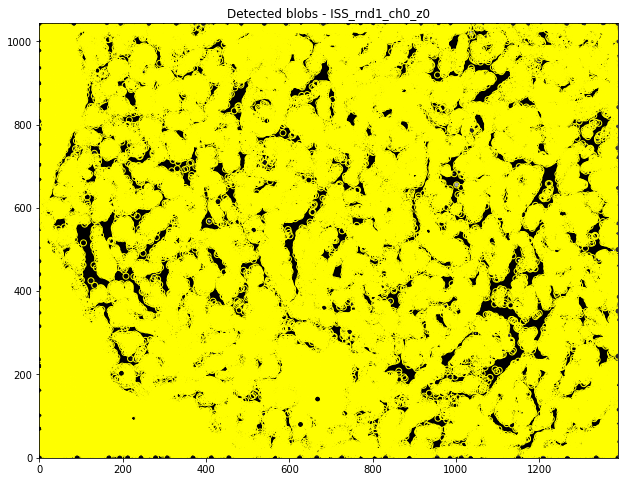

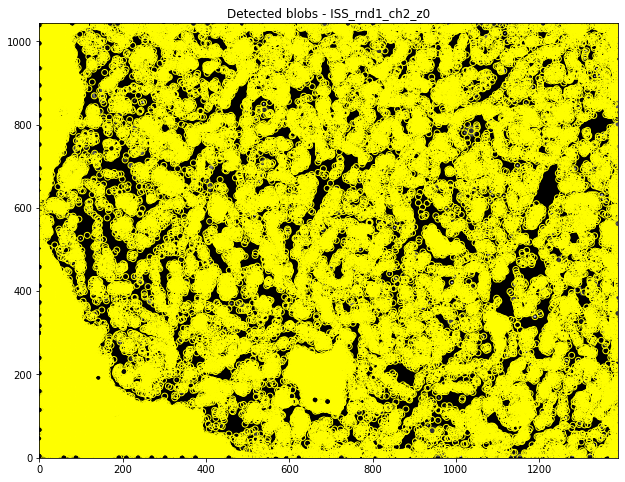

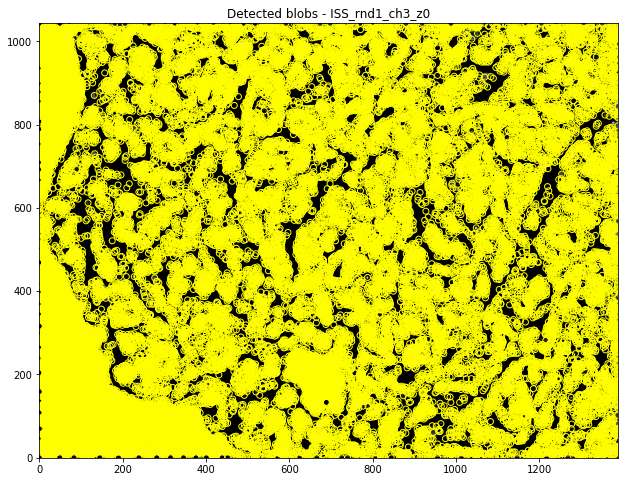

KeyboardInterrupt: 

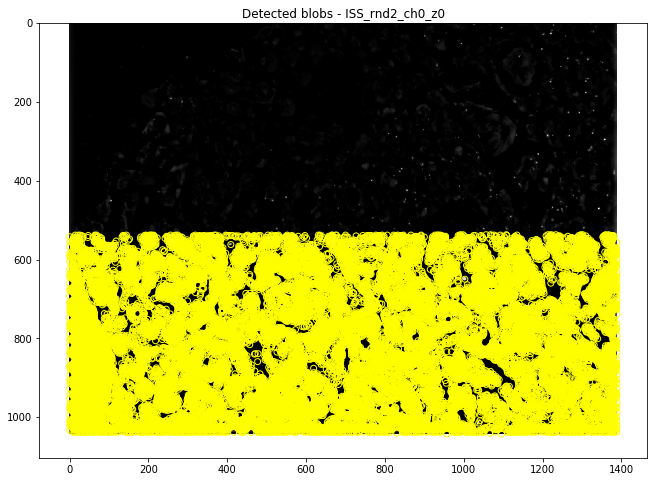

In [7]:
for img_path, test_img_filename in zip(test_img_paths, test_img_filenames):
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))
    
    plt.figure(figsize=(12, 8))
    plt.title('Detected blobs - %s'% test_img_filename)
    im = imread(img_path)
    plt.imshow(im, cmap='gray')
    for x, y in blobs:
        plt.scatter([x], [y], facecolors='None', edgecolors='yellow')
    plt.xlim(0, im.shape[1])
    plt.ylim(0, im.shape[0])
    plt.show()

# Part 3: Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection
- Outputs:
    - crops ready to be sent to mechanical turkers

In [ ]:
if not os.path.exists('./test_images_filtered_add/crops/'):
    os.mkdir('./test_images_filtered_add/crops/')
    
for img_path, img_name in zip(test_img_paths, test_img_filenames):
    
    crops_path = './test_images_filtered_add/crops/%s/' % img_name
    
    if not os.path.exists(crops_path):
        os.mkdir(crops_path)
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))

    image_width = imread(img_path).shape[1]
    crosshair_arm_length = crosshair_ratio * image_width
    
    autocrop.autocrop(blobs, img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio)
    

# Part 4: QC and Reassembly

### This section of the pipeline:

- Inputs:
    - annotations from Quanti.us for each crop
- Outputs:
    - total consensus annotations for each image

### QC, save consensus coords

In [ ]:
if not os.path.exists('./consensus_add/'):
    os.mkdir('consensus_add')

In [ ]:
for test_img_filename in test_img_filenames:
    crops_path = './crops_add/%s/' % test_img_filename
    json_filepath = './anno_add/%s.json' % test_img_filename
    img_filenames = [f for f in os.listdir(crops_path) if f.endswith('.png')]

    for img_filename in img_filenames:

        print('Now processing %s' % (img_filename))

        img_filepath = './crops_add/%s/%s' % (test_img_filename, img_filename)

        qa = QuantiusAnnotation(json_filepath, img_filename)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()

        # cluster annotations
        clusters = sa.get_clusters(anno_all, clustering_params)  

        # apply QC
        cluster_size_threshold = clus.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)

        clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        clusters_post_qc = nonclumpy_clusters

        if len(clumpy_clusters.index) is not 0:
            for i in range(len(clumpy_clusters.index)):
                subclusters = clus.declump(clumpy_clusters, i, declumping_params)
            clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

        # save consensus coords        
        im = imread(img_filepath)
        img_height = len(im)
        clusters_post_qc_list = []
        for index in clusters_post_qc.index:
            row = clusters_post_qc.iloc[index]
            x, y = row['centroid_x'], row['centroid_y']
            clusters_post_qc_list.append([x, img_height-y])
        path = ('./consensus_add/%s' % img_filename).replace('png', 'csv')
        np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')


## Reassembly of consensus coords, save reassembled coords

In [ ]:
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'violet', 'magenta']    


In [ ]:
for test_img_filename in test_img_filenames:
    blacked_path = './consensus_add/' + test_img_filename + '/' + test_img_filename + '_blacked.csv'
    total = []
    coords_blacked = np.asarray(pd.read_csv(blacked_path))

    for coord in coords_blacked:
        plt.scatter(coord[0], coord[1], color = 'black')
        total.append([coord[0], coord[1]])

    for i in range(4):
        coords_path = './consensus_add/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
        coords = np.asarray(pd.read_csv(coords_path))
        stats_path = './crops_add/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
        stats = np.asarray(pd.read_csv(stats_path, header = None))
        xmin = stats[0][0]
        ymin = stats[2][0]
        ymax = stats[3][0]
        height = ymax - ymin
        zoom_factor = stats[4][0]

        refit = []
        for coord in coords:
            x = coord[0]/zoom_factor + xmin
            y = coord[1]/zoom_factor + ymin
            refit.append([x, y])
            total.append([x, y])
        refit = np.asarray(refit)

        for coord in refit:
            plt.scatter(coord[0], coord[1], color = colors[i])

    plt.title('All centroids - %s' % test_img_filename)
    plt.show()
    
    np.savetxt('./consensus_add/' + test_img_filename + '/total.csv', np.asarray(total), delimiter=",", comments='', header='centroid_x,centroid_y')
    

In [ ]:
for img_path, test_img_filename in zip(test_img_paths, test_img_filenames):

    blobs_filepath = './test_images_filtered_add/blobs/%s.csv' % test_img_filename
    blobs_coords = np.asarray(pd.read_csv(blobs_filepath))
    consensus_total_path = './consensus_add/%s/total.csv' % test_img_filename
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))
    
    plt.figure(figsize=(12,8))
    for x, y in blobs_coords:
        plt.scatter([x], [y], c='xkcd:pink')
    
    for x, y in consensus_coords:
        plt.scatter([x], [y], edgecolor='blue', facecolor='None')
        
    im = imread(img_path)
    plt.imshow(im, cmap='gray')
    
    plt.title('Blobs (pink) and Consensus (blue), %s' % test_img_filename)    
    plt.show()


# Part 5: Evaluation

## Blob Detection vs. Reference

In [ ]:
data = []

for img_path, test_img_filename in zip(test_img_paths, test_img_filenames):

    im = imread(img_path)
    
    print('-----------------\n\n%s\n\n-----------------' % test_img_filename)

    blobs_filepath = './test_images_filtered_add/blobs/%s.csv' % test_img_filename
    blobs_coords = np.asarray(pd.read_csv(blobs_filepath))
    blobs_kdt = KDTree(blobs_coords, leaf_size=2, metric='euclidean')
    
    consensus_total_path = './consensus_add/%s/total.csv' % test_img_filename
    consensus_coords = np.asarray(pd.read_csv(consensus_total_path))
    consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')
    
    correct_blob = []
    incorrect_blob = []
    detected_consensus = []
    undetected_consensus = []

    # correct vs. incorrect
    
    for blob_coord in blobs_coords:
        dist, ind = consensus_kdt.query([blob_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blob.append(blob_coord)
        else:
            incorrect_blob.append(blob_coord)

    # detected vs. undetected

    for consensus_coord in consensus_coords:
        dist, ind = blobs_kdt.query([consensus_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_consensus.append(consensus_coord)
        else:
            undetected_consensus.append(consensus_coord)  
            
    precision = len(correct_blob)/len(blobs_coords)
    recall = len(detected_consensus)/len(consensus_coords)
        
    # plot Precision
    plt.figure(figsize=(12,7))
    for x, y in correct_blob:
        plt.scatter(x, y, edgecolors='green', facecolors='None')
    for x, y in incorrect_blob:
        plt.scatter(x, y, edgecolors='magenta', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Precision = %s' % (test_img_filename, round(precision, 2)))
    plt.show()
    
    # plot Recall
    plt.figure(figsize=(12,7))
    for x, y in detected_consensus:
        plt.scatter(x, y, edgecolors='cyan', facecolors='None')
    for x, y in undetected_consensus:
        plt.scatter(x, y, edgecolors='orange', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Recall = %s' % (test_img_filename, round(recall, 2)))
    plt.show()
    
    data.append([test_img_filename, precision, recall])

In [ ]:
precision = [x[1] for x in data]
recall = [x[2] for x in data]

In [ ]:
list(precision)

In [ ]:
plt.figure(figsize=(3,4))
plt.bar(x=[1,1.8], height=[np.mean(precision), np.mean(recall)], color=['xkcd:light gray', 'xkcd:gray'], edgecolor=['black', 'black'])

(_, caps, _) = plt.errorbar([1,1.8], [np.mean(precision), np.mean(recall)], yerr=[np.std(precision), np.std(recall)], fmt="None", color='black', linewidth=None, capsize=10, elinewidth=2, alpha=1)
for cap in caps:
    cap.set_color('black')
    cap.set_markeredgewidth(2)
    
plt.xticks([1,1.8], ['Precision', 'Recall'])
plt.yticks([0, 0.5, 1])
plt.ylabel('Proportion')
plt.savefig('results_thirteen_rca_images_based_on_consensus_normalized.pdf', transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
np.mean(recall)